### Notes and Ideas
The original codes are implemented using jax, which is a little hard for us to understand at the beginning, we instead using the standard numpy to implement at first.

In [77]:
# % matplotlib inline
import matplotlib.pyplot as plt
import time
import math
import itertools
import numpy as np
from scipy.stats import nbinom
from functools import partial
import scipy.stats
from scipy.stats import bernoulli
from dataclasses import dataclass, asdict
import sklearn.metrics as metrics
from textwrap import wrap
import random
from sklearn.model_selection import train_test_split

import jax
import jax.numpy as jnp
import jax.nn as jnn
# import jax.

## Model Description

### **Probability of infection:**

$$Q_j = 1 - \exp(-\mu R_j)$$

### **Overall risk score for user with multiple exposures**

$$R_j = \sum_{n\in E_j} r_n$$

### **Risk score for single exposure:**
first term is the weighted exposure minutes, second term is the weighted contagiousness level

$$r_n = \left[\sum_{b=1}^{N_B} \tau_{nb} w_b^{\text{ble}}\right] \quad \times \quad \left[\sum_{l=1}^{N_C} I(c_{n,l})w_l^{\text{con}}\right]$$

### **Weighted exposure:**
determined by the distance (proxied by Bluetooth attenuation) and the duration of exposure

* Monotonicity (ensure that risk score is monotonically increasing): reparameterize $w^{\text{ble}}$ 

$$w^{\text{ble}} = [w_1^{\text{ble}}, w_2^{\text{ble}} = w_1^{\text{ble}} + \Delta_2^{\text{ble}}, w_3^{\text{ble}} = w_2^{\text{ble}} + \Delta_3^{\text{ble}}, w_4^{\text{ble}} = w_3^{\text{ble}} + \Delta_4^{\text{ble}}]$$
 
  and optimize over $(w^{\text{ble}}_1, \Delta_2^{\text{ble}},\Delta_3^{\text{ble}},\Delta_4^{\text{ble}})$ 

* Replacing discrete attenuation threshold function with continuous, soft thresholding by replacing hard binning with sigmoid function

\begin{aligned}
\tau_{nb} &= \sum_k \tau_{nk} I \left(\theta^{\text{ble}}_{b-1} < a_{nk} \leq \theta^{\text{ble}}_{b}\right)\\
& \approx \sum_k \tau_{nk} \sigma_\tau (a_{nk} - \theta^{\text{ble}}_{b-1}) \sigma_\tau(\theta^{\text{ble}}_{b}-a_{nk})\\
\end{aligned}

### **Weighted Contagiousness Level:**
\begin{equation*}
f_{\text{con}}(c_n; \psi)=\begin{cases}
          0 \quad &\text{if} \, c_n = 1 \\
          w_2^{\text{con}} \quad &\text{if} \, c_n = 2 \\
          w_3^{\text{con}} \quad &\text{if} \, c_n = 3 \\
     \end{cases}
\end{equation*}

## Implementation of Helper Functions

In [78]:
### Helper Functions

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Bluetooth attenuation effect
def f_ble(tnb, w_ble):
    '''
    tnb  :  1 x 4 array of duration in each bucket
    w_ble:  1 x 4 array of weights for bluetooth attenuation
    '''
    w = np.array(([w_ble[0], sum(w_ble[:2]), sum(w_ble[:3]), sum(w_ble[:4])]))
    return np.sum(tnb * w)


# Soft binning for time parameter
def exposure_duration(tnk, ank, t_ble):
    '''
    tnk  :  k x 4 array of duration corresponding to bluetooth attenuation strength
    ank  :  k x 4 array of bluetooth attenuation strength
    t_ble:  1 x 3 array of thresholds for bluetooth attenuation
    '''
    t_ble = np.hstack((np.hstack((0, t_ble)), np.inf))
    return np.sum(tnk * sigmoid(ank - t_ble[:4]) * sigmoid(t_ble[1:] - ank), axis=0)


# Contagiousness level function
def f_con(cn, w_con):
    '''
    cn   :  quantized symptom onset time
    w_con:  1 x 2 array of contagiousness weights
    '''
    if cn == 1:
        return 0
    elif cn == 2:
        return w_con[0]
    else:
        return w_con[1]


# Risk score function
def risk_score(tnk, ank, t_ble, w_ble, cn, w_con):
    '''
    tnk  :  k x 4 array of duration corresponding to bluetooth attenuation strength
    ank  :  k x 4 array of bluetooth attenuation strength
    t_ble:  1 x 3 array of thresholds for bluetooth attenuation
    w_ble:  1 x 4 array of weights for bluetooth attenuation
    cn   :  quantized symptom onset time
    w_con:  1 x 2 array of contagiousness weights
    '''
    tnb = exposure_duration(tnk, ank, t_ble)
    rn = f_ble(tnb, w_ble) * f_con(cn, w_con)
    return np.sum(rn)


# Probability of infection
def infection_prob(rj, mu):
    return 1 - np.exp(-mu * rj)


# Loss Function
def loss(y, q):
    return np.sum(y * np.log(q) + (1 - y) * np.log(1 - q))


# initial weight
def generate_init_weights():
    """Initial (residual) parameters for learning. """
    weights_duration = np.random.rand(3) * 0.001  # random init
    weights = weights_duration
    return weights

## Data Generation

In [79]:
### Original Data Generating Func

@dataclass
class BleParams:
    slope: float = 0.21
    intercept: float = 3.92
    sigma: float = np.sqrt(0.33)
    tx: float = 0.0
    correction: float = 2.398
    name: str = 'briers-lognormal'


@dataclass
class ModelParams:
    ble_params: BleParams = BleParams()  # may want to change sigma
    distance_fun: str = 'quadratic'  # quadratic  or sigmoid
    distance_Dmin: float = 1.0
    distance_slope: float = 2.0
    distance_inflection: float = 2.0
    infectiousness_fun: str = 'skew-logistic'  # gaussian or skew-logistic
    beta: float = 1e-1  # transmission rate (the simulation Colab uses 1e-3)


@dataclass
class RiskConfig:
    ble_thresholds: jnp.array = jnp.array([])
    ble_weights: jnp.array = jnp.array([])
    inf_levels: jnp.array = jnp.array([])
    inf_weights: jnp.array = jnp.array([])
    name: str = ''
    beta: float = 3.1 * 1e-6  # Wilson table 1


def incubation_dist(t):
    mu = 1.621
    sig = 0.418
    rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
    return rv.pdf(t)


# Symptom days to infectiousness
def skew_logistic_scaled(x, alpha, mu, sigma):
    return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)


def ptost_conditional(ts, incubation):
    mu = -4
    sigma = 1.85
    alpha = 5.85
    tau = 5.42
    fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
    fneg = skew_logistic_scaled(ts * tau / incubation, alpha, mu, sigma)
    ps = fpos
    neg = jnp.where(ts < 0)
    ps[neg] = fneg[neg]
    ps = ps / np.max(ps)
    return ps


def ptost_uncond(tost_times):
    incub_times = np.arange(1, 14, 1)
    incub_probs = incubation_dist(incub_times)
    tost_probs = np.zeros_like(tost_times, dtype=float)
    for k, incub in enumerate(incub_times):
        ps = ptost_conditional(tost_times, incub)
        tost_probs += incub_probs[k] * ps
    return tost_probs


infectiousness_curve_times = np.arange(-14, 14 + 1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)


def infectiousness_skew_logistic(delta):
    return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)


# Distance to dose
def transmission_vs_distance_quadratic(d, Dmin=1):
    m = np.power(Dmin, 2) / np.power(d, 2)
    return np.minimum(1, m)


def uniform_input_data_grid(max_dur=60, max_dist=5, ngrid_dist=20, ngrid_dur=20, min_dist=0.1, min_dur=5):
    distances = np.linspace(min_dist, max_dist, ngrid_dist)  # meters
    durations = np.linspace(min_dur, max_dur, ngrid_dur)  # minutes
    symptoms = np.arange(-10, 10 + 0.001, dtype=int)  # must be int
    return distances, durations, symptoms


def make_input_data(sigma=0.1, nsamples=20, distances=None, durations=None, symptoms=None):
    if distances is None:
        distances, durations, symptoms = uniform_input_data_grid()
    ble_params = BleParams()
    attens = dist_to_atten(distances, ble_params)

    # Make 3d cross product of the three 1d inputs
    vals = itertools.product(distances, durations, symptoms)
    X = np.vstack([np.array(v) for v in vals])
    distance_grid = X[:, 0]
    duration_grid = X[:, 1]
    symptom_grid = np.array(X[:, 2], dtype=int)
    n = len(distance_grid)
    print('Making grid of {} distances x {} durations x {} onsets = {} points'.format(
        len(distances), len(durations), len(symptoms), n))

    # noise-free atteniations
    atten_grid = dist_to_atten(distance_grid, ble_params)

    # noisy samples
    atten_grid_samples = []
    for n in range(nsamples):
        sample = dist_to_atten_sample(distance_grid, ble_params, sigma)
        atten_grid_samples.append(sample)

    # Make 2d matrix for surface plotting functions (for fixed duration)
    grid_2d_matrix = np.meshgrid(symptoms, attens)
    symptom_grid_2d_matrix, atten_grid_2d_matrix = grid_2d_matrix
    vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
    X = np.vstack([np.array(v) for v in vals])
    symptom_grid_2d = np.array(X[:, 0], dtype=int)
    atten_grid_2d = X[:, 1]

    data = {
        'distance_grid': distance_grid, 'atten_grid': atten_grid,
        'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
        'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
        'atten_grid_2d_matrix': atten_grid_2d_matrix,
        'symptom_grid_2d': symptom_grid_2d,
        'atten_grid_2d': atten_grid_2d,
        'atten_grid_samples': atten_grid_samples,
        'noise_level': sigma, 'nsamples': nsamples}
    return data


# Transmission model
def hazard_fun_batch(attenuations, durations, symptom_days, params, distances=None):
    """
    Args:
      params = ModelParams() object.
    """
    if distances is None:
        distances = atten_to_dist(attenuations, params.ble_params)
    if params.distance_fun == 'quadratic':
        fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
    elif params.distance_fun == 'sigmoid':
        fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
    elif params.distance_fun == 'spline':
        fd = transmission_vs_distance_spline(distances)
    if params.infectiousness_fun == 'gaussian':
        finf = infectiousness_gaussian(symptom_days)
    elif params.infectiousness_fun == 'skew-logistic':
        finf = infectiousness_skew_logistic(symptom_days)
    doses = durations * fd * finf
    return doses


def prob_infection_batch(attenuations, durations, symptom_days, params, approx='taylor', exp_taylor_terms=np.inf,
                         temp=1, distances=None):
    """
    Args:
      params = ModelParams() object.
    """
    doses = hazard_fun_batch(attenuations, durations, symptom_days, params, distances)
    prob_infect_exact = 1 - np.exp(-params.beta * doses)
    if not (isinstance(temp, list) or isinstance(temp, np.ndarray)):
        temp = list(temp)

    if approx == 'none' or (approx == 'taylor' and exp_taylor_terms == np.inf) or (
            approx == 'tempered' and len(temp) == 1 and temp[0] == 1):
        prob_infect_approx = prob_infect_exact
    elif approx == 'taylor' and exp_taylor_terms < np.inf:
        prob_infect_approx = []
        x = -params.beta * doses
        prob_infect = np.zeros(len(doses))
        for k in range(1, exp_taylor_terms + 1):
            prob_infect -= x ** k / math.factorial(k)
            prob_infect_approx.append(np.minimum(np.maximum(prob_infect, 0), 1))
    elif approx == 'tempered':
        prob_infect_approx = []
        x = -params.beta * doses
        for t in temp:
            prob_infect = 1 - np.power(np.maximum(1 + (1 - t) * x, 0), 1 / (1 - t))
            prob_infect_approx.append(prob_infect)
    else:
        raise ValueError("Unknnown approximation type: {}".format(approx))
    return prob_infect_exact, prob_infect_approx


def prob_infection_grid(data, params, approx='none', exp_taylor_terms=np.inf, temp=1):
    """
    Args:
      data = dictionary obtained from make_input_data().
      params = ModelParams() object.
      approx: Approximation for the exponential function for simulating model mismatch (none/taylor/tempered)
      exp_taylor_terms: Number of approximation terms to use for Taylor approximation
      temp: Array of temperature parameters for 'tempered' approximation
    """
    ps = prob_infection_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], params, approx,
                              exp_taylor_terms, temp)
    return ps


def risk_score_grid(data, config):
    rs = risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
    return rs


def prob_risk_score_grid(data, config):
    qs = prob_risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
    return qs


def risk_score_grid_sample(data, config, ndx):
    rs = risk_score_batch(data['atten_grid_samples'][ndx], data['duration_grid'], data['symptom_grid'], config)
    return rs


def atten_to_rssi(atten, ble_params):
    return ble_params.tx - (atten + ble_params.correction)


def rssi_to_atten(rssi, ble_params):
    return ble_params.tx - (rssi + ble_params.correction)


def atten_to_dist(atten, ble_params):
    rssi = ble_params.tx - (atten + ble_params.correction)
    return np.exp((np.log(-rssi) - ble_params.intercept) / ble_params.slope)


def dist_to_atten(distance, ble_params):
    mu = ble_params.intercept + ble_params.slope * np.log(distance)
    rssi = -np.exp(mu)
    atten = ble_params.tx - (rssi + ble_params.correction)
    return atten


# This will be used in the future to add noise
def dist_to_atten_sample(distances, ble_params, sigma):
    # if ble_params.sigma == 0:
    if sigma == 0:
        return dist_to_atten(distances, ble_params)
    N = len(distances)
    mus = ble_params.intercept + ble_params.slope * np.log(distances)
    # sigs = ble_params.sigma
    sigs = sigma
    rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
    atten = ble_params.tx - (rssi + ble_params.correction)
    return atten


def make_infectiousness_params_v2():
    # Derived from Arizona by averaging some bins
    inf_pre = np.zeros((9), dtype=int)
    inf_post = np.zeros((5), dtype=int)
    inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
    inf_mid = np.ones_like(inf_mid6)
    ndx = (inf_mid6 >= 5)
    inf_mid[ndx] = 2
    #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
    inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
    inf_weights = np.array([0, 10 ** 1.6, 10 ** 2]) / 100
    return inf_levels, inf_weights


def days_to_inf_levels(symptom_days):
    symptom_days = np.atleast_1d(symptom_days)  # turn into array
    inf_levels, _ = make_infectiousness_params_v2()
    return inf_levels[symptom_days + 14]


distances, durations, symptoms = uniform_input_data_grid(max_dur=60, max_dist=5, ngrid_dist=80, ngrid_dur=20,
                                                         min_dist=0.1, min_dur=5)
data = make_input_data(distances=distances, durations=durations, symptoms=symptoms)

ble_params = BleParams()
rssi = atten_to_rssi(data['atten_grid'], ble_params)
duration = data['duration_grid']
symptom_day = data['symptom_grid']
infectiousness = days_to_inf_levels(symptom_day)

params = ModelParams()

# Create model inputs
X = np.concatenate([rssi[:, None], duration[:, None], infectiousness[:, None]], axis=1)
approx_type = 'taylor'
exp_taylor_terms = 8
exp_temperature = np.arange(0.5, 1., 0.09)

prob_infect_exact, prob_infect_approx = prob_infection_grid(data, params, approx=approx_type,
                                                            exp_taylor_terms=exp_taylor_terms, temp=exp_temperature)
prob_infect_approx = np.array(prob_infect_approx)
# manually inspect the approximation error (higher error for larger values -- away from 0)
ind = np.where(prob_infect_exact > 0.6)
print('Approx:', prob_infect_approx[:, ind])
print('Exact:', prob_infect_exact[ind])

print(X.shape, prob_infect_exact.shape)

simdata = dict()
simdata['X'] = X
simdata['prob_infect_exact'] = prob_infect_exact
simdata['prob_infect_approx'] = prob_infect_approx


Making grid of 80 distances x 20 durations x 21 onsets = 33600 points
Approx: [[[1.         1.         1.         ... 0.97538178 0.92937435 0.92675691]]

 [[0.49996063 0.49998181 0.46092688 ... 0.49969697 0.49750601 0.49731772]]

 [[0.67110338 0.66968263 0.81008083 ... 0.65435507 0.63129513 0.62997964]]

 ...

 [[0.63518322 0.63414931 0.72087815 ... 0.62280329 0.60509304 0.60406036]]

 [[0.63539429 0.63435626 0.72199235 ... 0.62296994 0.60521186 0.60417686]]

 [[0.63536768 0.63433023 0.72181414 ... 0.62294962 0.60519806 0.60416337]]]
Exact: [0.63537038 0.63433287 0.72183658 ... 0.62295162 0.60519936 0.60416464]
(33600, 3) (33600,)


In [80]:
X_epi = simdata['X']
probabilities_true_epi = simdata['prob_infect_exact']
probabilities_true_epi_approx = simdata['prob_infect_approx'].T  # N x num_approx_steps
N = len(probabilities_true_epi)
perm = np.random.permutation(N)
X_epi = X_epi[perm, :]
probabilities_true_epi = probabilities_true_epi[perm]
probabilities_true_epi_approx = np.clip(probabilities_true_epi_approx[perm, :], 1e-5, 1 - 1e-5)


def sample_labels(probabilities):
    Y = bernoulli.rvs(probabilities)
    N_pos = np.sum(Y)
    N_neg = np.sum(1 - Y)
    print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))
    pos_neg_ratio = float(N_neg) / N_pos
    return Y, N_pos, N_neg, pos_neg_ratio


Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)

total: 33600, positives: 5398, negatives: 28202


In [81]:
len(Y_epi)

33600

In [82]:
simdata

{'X': array([[-31.07666234,   5.        ,   0.        ],
        [-31.07666234,   5.        ,   0.        ],
        [-31.07666234,   5.        ,   0.        ],
        ...,
        [-70.66723028,  60.        ,   1.        ],
        [-70.66723028,  60.        ,   1.        ],
        [-70.66723028,  60.        ,   0.        ]]),
 'prob_infect_exact': array([0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
        0.0021102 ]),
 'prob_infect_approx': array([[0.00123653, 0.00276669, 0.00596975, ..., 0.00618441, 0.00361772,
         0.00211243],
        [0.00123577, 0.00276287, 0.00595193, ..., 0.00616529, 0.00361118,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        ...,
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00595197, ..., 0.00616533, 0.00361119,
         0.0021102 ],
        [0.00123577, 0.00276287, 0.00

## Data Bagging

After creating this "pool" of exposure events, we next assigned a random bag of size $k$ of these events to each user. The value $k$ is sampled from a truncated negative binomial distribution with parameters $(p; r)$, where the truncation parameter is the maximum bag size $b$. 

Negative bags are composed of all negative exposures. We consider two scenarios for constructing positive bags: (i) each positive bag contains exactly one positive exposure and
rest are negative exposures, (ii) each positive bag contains $N$ positive exposures, where $N$ is sampled uniformly from {1; 2; 3}.

In [99]:
### Self-defined function to simulate bags
### Create a class for simulating bags

class Bag_Simulator():
    def __init__(self, p_pos, r_pos, p_neg, r_neg, max_bag_size, censor_prob_pos, censor_prob_neg, max_pos_in_bag=3):
        self.p_pos = p_pos
        self.r_pos = r_pos
        self.p_neg = p_neg
        self.r_neg = r_neg
        self.max_bag_size = max_bag_size
        self.censor_prob_pos = censor_prob_pos
        self.censor_prob_neg = censor_prob_neg
        self.max_pos_in_bag = max_pos_in_bag

    def get_pos_neg_bag_sizes(self, bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos, N_neg, pos_neg_ratio,
                              max_pos_in_bag=1, N_pos_bags=None):

        if max_pos_in_bag > max(bag_sizes):
            raise ValueError("max_pos_in_bag needs to be less than or equal to bag_sizes")
        if N_pos_bags is None:
            raise ValueError("Please give an input for N_pos_bags")
        N_pos_bags_incr = -10
        while True:
            N_neg_bags = int(N_pos_bags * pos_neg_ratio)
            pos_bag_size_samples = np.random.choice(bag_sizes, size=N_pos_bags, replace=True, p=pos_bag_size_probs)
            pos_samples_per_bag = np.random.choice(np.arange(1, max_pos_in_bag + 1), size=N_pos_bags, replace=True)
            N_pos_required = np.sum(pos_samples_per_bag)
            neg_bag_size_samples = np.random.choice(bag_sizes, size=N_neg_bags, replace=True, p=neg_bag_size_probs)
            N_neg_required = np.sum(pos_bag_size_samples) - N_pos_required + np.sum(neg_bag_size_samples)
            if N_neg_required < N_neg and N_pos_required < N_pos:
                break
            else:
                N_pos_bags += N_pos_bags_incr  # increment the number of positive bags

        N_neg_bags = int(N_pos_bags * pos_neg_ratio)
        N_pos_required = np.sum(pos_samples_per_bag)
        N_neg_required = np.sum(pos_bag_size_samples) - N_pos_required + np.sum(neg_bag_size_samples)
        return pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags, N_neg_bags, N_pos_required, N_neg_required

    @staticmethod
    def get_neg_bino_norm(k, n, p):
        temp_pmf = nbinom.pmf(k, n, p)

        return temp_pmf / np.sum(temp_pmf)

    @staticmethod
    def train_test_split_func(mat, labels, N_pos_bags, N_neg_bags, train_ratio=0.8, order=True):
        N_bags = N_pos_bags + N_neg_bags
        N_pos_trn = int(N_pos_bags * train_ratio)
        N_neg_trn = int(N_neg_bags * train_ratio)
        if order:
            ind_trn = list(np.arange(N_pos_trn)) + list(np.arange(N_pos_bags, N_pos_bags + N_neg_trn))
            ind_tst = list(np.arange(N_pos_trn, N_pos_bags)) + list(np.arange(N_pos_bags + N_neg_trn, N_bags))
            # shuffle the rows of train and test assignment matrices
            random.shuffle(ind_trn)
            random.shuffle(ind_tst)
            assign_mat_trn = mat[ind_trn]
            assign_mat_tst = mat[ind_tst]
            bag_labels_trn = labels[ind_trn]
            bag_labels_tst = labels[ind_tst]
        else:
            assign_mat_trn_part_1, assign_mat_tst_part_1, bag_labels_trn_part_1, bag_labels_tst_part_1 = train_test_split(
                mat[:N_pos_bags], labels[:N_pos_bags], train_size=train_ratio)
            assign_mat_trn_part_2, assign_mat_tst_part_2, bag_labels_trn_part_2, bag_labels_tst_part_2 = train_test_split(
                mat[N_pos_bags:], labels[N_pos_bags:], train_size=train_ratio)
            assign_mat_trn = np.concatenate((assign_mat_trn_part_1, assign_mat_trn_part_2), axis=0)
            assign_mat_tst = np.concatenate((assign_mat_tst_part_1, assign_mat_tst_part_2), axis=0)
            bag_labels_trn = np.concatenate((bag_labels_trn_part_1, bag_labels_trn_part_2), axis=0)
            bag_labels_tst = np.concatenate((bag_labels_tst_part_1, bag_labels_tst_part_2), axis=0)
        # remove examples with zero exposures, if any (due to censoring)
        ind_valid_trn = np.where(np.sum(assign_mat_trn, axis=1) > 0)[0]
        ind_valid_tst = np.where(np.sum(assign_mat_tst, axis=1) > 0)[0]
        assign_mat_trn = assign_mat_trn[ind_valid_trn]
        assign_mat_tst = assign_mat_tst[ind_valid_tst]
        bag_labels_trn = bag_labels_trn[ind_valid_trn]
        bag_labels_tst = bag_labels_tst[ind_valid_tst]

        return assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst

    def simulate_bagged_data(self, X, Y, probabilities):
        max_bag_size = self.max_bag_size
        bag_sizes = np.arange(start=1, stop=max_bag_size + 1, step=1)
        max_pos_in_bag_low = min(max_bag_size, self.max_pos_in_bag)
        # probability of an exposure being censored or hidden from the App
        censor_prob_pos = self.censor_prob_pos
        censor_prob_neg = self.censor_prob_neg

        # probabilities for bag sizes
        # next assigned a random bag of size k of these events to each user.
        # The value k is sampled from a truncated negative binomial distribution with parameters (p; r)
        # where the truncation parameter is the maximum bag size b.
        pos_bag_size_probs = self.get_neg_bino_norm(np.arange(max_bag_size), self.r_pos, 1 - self.p_pos)
        neg_bag_size_probs = self.get_neg_bino_norm(np.arange(max_bag_size), self.r_neg, 1 - self.p_neg)

        # Sample bag sizes. Maintain same ratio of +ve to -ve bags as the ratio of +ve to -ve examples.
        # Each positive bag has exactly one +ve example (exposure). Each negative bag has all -ve exposures.
        N_pos = np.sum(Y)
        N_neg = np.sum(1 - Y)
        pos_neg_ratio = float(N_neg) / N_pos
        print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))
        pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags, N_neg_bags, N_pos_required, N_neg_required = self.get_pos_neg_bag_sizes(
            bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos, N_neg, pos_neg_ratio,
            max_pos_in_bag=max_pos_in_bag_low, N_pos_bags=710)
        N_bags = N_pos_bags + N_neg_bags
        print('Empirical Bag sizes:')
        print('\t Positive bags: mean size {:.3f}, median size {:d}'.format(np.mean(pos_bag_size_samples),
                                                                            int(np.median(pos_bag_size_samples))))
        print('\t Negative bags: mean size {:.3f}, median size {:d}'.format(np.mean(neg_bag_size_samples),
                                                                            int(np.median(neg_bag_size_samples))))
        print('required -ve exposures:', N_neg_required)
        print('available -ve exposures:', N_neg)

        # The following conditions should hold.
        assert N_neg_required < N_neg
        assert N_pos_required < N_pos

        # ---------- Assign exposures to bags ---------------
        # indices of +ve and -ve exposures
        ind_pos_exposures = list(np.where(np.array(Y == 1))[0][0:N_pos_required])
        ind_neg_exposures = list(np.where(np.array(Y == 0))[0][0:N_neg_required])
        # keep only required exposures
        Y_filt = Y[ind_pos_exposures + ind_neg_exposures]
        X_filt = X[ind_pos_exposures + ind_neg_exposures]
        probabilities_filt = probabilities[ind_pos_exposures + ind_neg_exposures]
        # shuffle the order
        Z = np.concatenate((X_filt, Y_filt[:, None], probabilities_filt[:, None]), axis=1)
        np.random.shuffle(Z)
        X_shuff = Z[:, :X_filt.shape[1]]
        Y_shuff = Z[:, X_filt.shape[1]]
        probabilities_shuff = Z[:, -1]

        # indices of +ve and -ve exposures
        ind_pos_exposures = np.where(np.array(Y_shuff == 1))[0]
        ind_neg_exposures = np.where(np.array(Y_shuff == 0))[0]
        N_samples = np.sum(pos_bag_size_samples) + np.sum(neg_bag_size_samples)

        # construct binary assignment matrix: Bags x Exposures
        assign_mat = np.zeros((N_bags, N_samples))
        bag_labels = np.zeros(N_bags)
        bag_labels[:N_pos_bags] = 1
        running_ind_pos = 0
        running_ind_neg = 0
        # We consider two scenarios for constructing positive bags: (i) each positive bag contains exactly one positive exposure and
        # rest are negative exposures, (ii) each positive bag contains N positive exposures, where N is sampled uniformly from {1; 2; 3}
        for i in range(N_pos_bags):
            assign_mat[i, ind_pos_exposures[
                          running_ind_pos:running_ind_pos + pos_samples_per_bag[i]]] = 1 * bernoulli.rvs(
                1 - censor_prob_pos)
            running_ind_pos += pos_samples_per_bag[i]
            if pos_bag_size_samples[i] > 1:
                assign_mat[i, ind_neg_exposures[
                              running_ind_neg:running_ind_neg + pos_bag_size_samples[i] - pos_samples_per_bag[
                                  i]]] = 1 * bernoulli.rvs(1 - censor_prob_neg)
                running_ind_neg += pos_bag_size_samples[i] - pos_samples_per_bag[i]
        for i in range(N_neg_bags):
            assign_mat[i + N_pos_bags, ind_neg_exposures[
                                       running_ind_neg:running_ind_neg + neg_bag_size_samples[i]]] = 1 * bernoulli.rvs(
                1 - censor_prob_neg)
            running_ind_neg += neg_bag_size_samples[i]

        # train/test split
        trn_frac = 0.8
        N_pos_trn = int(N_pos_bags * trn_frac)
        N_neg_trn = int(N_neg_bags * trn_frac)
        N_trn = N_pos_trn + N_neg_trn
        ind_trn = list(np.arange(N_pos_trn)) + list(np.arange(N_pos_bags, N_pos_bags + N_neg_trn))
        # print(ind_trn)
        ind_tst = list(np.arange(N_pos_trn, N_pos_bags)) + list(np.arange(N_pos_bags + N_neg_trn, N_bags))
        # print(ind_tst)
        # shuffle the rows of train and test assignment matrices
        random.shuffle(ind_trn)
        random.shuffle(ind_tst)
        assign_mat_trn = assign_mat[ind_trn]
        assign_mat_tst = assign_mat[ind_tst]
        bag_labels_trn = bag_labels[ind_trn]
        bag_labels_tst = bag_labels[ind_tst]
        # remove examples with zero exposures, if any (due to censoring)
        ind_valid_trn = np.where(np.sum(assign_mat_trn, axis=1) > 0)[0]
        ind_valid_tst = np.where(np.sum(assign_mat_tst, axis=1) > 0)[0]
        assign_mat_trn = assign_mat_trn[ind_valid_trn]
        assign_mat_tst = assign_mat_tst[ind_valid_tst]
        bag_labels_trn = bag_labels_trn[ind_valid_trn]
        bag_labels_tst = bag_labels_tst[ind_valid_tst]

        print('Assignment matrix size:', assign_mat.shape, assign_mat_trn.shape, X_shuff.shape)
        print('Train size: {}(+{}/-{}), test size: {}(+{}/-{})'.format(N_trn, N_pos_trn, N_neg_trn, N_bags - N_trn,
                                                                       N_pos_bags - N_pos_trn, N_neg_bags - N_neg_trn))
        print('Average positive samples per bag: {}'.format(np.mean(pos_samples_per_bag)))

        return X_shuff, probabilities_shuff, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst

    def visual_analysis(self):
        bag_sizes = np.arange(start=1, stop=self.max_bag_size + 1, step=1)

        # visualize bag statistics
        plt.stem(np.arange(self.max_bag_size, dtype=np.int) + 1, self.pos_bag_size_probs)
        plt.xticks(np.arange(1, self.max_bag_size + 1, 2), np.arange(1, self.max_bag_size + 1, 2))
        plt.title('Prob. of positive bag sizes')
        plt.show()
        plt.stem(np.arange(self.max_bag_size, dtype=np.int) + 1, self.neg_bag_size_probs)
        plt.xticks(np.arange(1, self.max_bag_size + 1, 2), np.arange(1, self.max_bag_size + 1, 2))
        plt.title('Prob. of negative bag sizes')
        plt.show()
        print('Expected bag sizes:')
        print('\tPositive bags: {:.3f}'.format(np.sum(np.multiply(bag_sizes, self.pos_bag_size_probs))))
        print('\tPositive bags: {:.3f}'.format(np.sum(np.multiply(bag_sizes, self.neg_bag_size_probs))))

In [100]:
bag_sim = Bag_Simulator(p_pos=0.7, r_pos=2, p_neg=0.7, r_neg=2, max_bag_size=1, censor_prob_pos=0, censor_prob_neg=0)
X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi)


total: 33600, positives: 5398, negatives: 28202
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
required -ve exposures: 3709
available -ve exposures: 28202
Assignment matrix size: (4419, 4419) (3535, 4419) (4419, 3)
Train size: 3535(+568/-2967), test size: 884(+142/-742)
Average positive samples per bag: 1.0


In [101]:
bag_sim = Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0, censor_prob_neg=0)
X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = bag_sim.simulate_bagged_data(X_epi, Y_epi, probabilities_true_epi)

total: 33600, positives: 5398, negatives: 28202
Empirical Bag sizes:
	 Positive bags: mean size 3.858, median size 3
	 Negative bags: mean size 3.946, median size 3
required -ve exposures: 15937
available -ve exposures: 28202
Assignment matrix size: (4419, 17375) (3535, 17375) (17375, 3)
Train size: 3535(+568/-2967), test size: 884(+142/-742)
Average positive samples per bag: 2.0253521126760563


In [86]:
## Sample bag simulation configuation
# To simulate censored exposures, we censor the positive exposures in each positive bag
# independently and identically with probability varying in the range f0:05; 0:1; 0:2; : : : ; 0:8g.
# We do not censor the negative exposures to prevent the bag sizes from changing too much
# from the control value.

bag_sims = [
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.05, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.1, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.2, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.3, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.4, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.5, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.6, censor_prob_neg=0),
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=16, censor_prob_pos=0.7, censor_prob_neg=0),
]

## Implementation and Optimization

use of SGD, etc.

There are 10 parameters in total to learn

In [87]:
def print_params(weights, n_rssi_buckets=4):
    """print parameters"""
    n_rssi_th = n_rssi_buckets - 1
    beta = weights[0]
    ind = 1
    rssi_w = weights[ind:ind + n_rssi_buckets]
    ind += n_rssi_buckets
    rssi_th = weights[ind:ind + n_rssi_th]
    ind += n_rssi_th
    infect_w = weights[ind:ind + n_infect_levels]
    print('\tbeta: {:.6f}'.format(beta))
    print('\trssi_w: {}'.format([round(w, 3) for w in rssi_w]))
    print('\trssi_th: {}'.format([round(w, 4) for w in rssi_th]))
    print('\tinfectiousness: {}'.format([round(w, 2) for w in infect_w]))

In [88]:
# basic configuration
n_rssi_buckets = 4
n_infect_levels = 3
rssi_lowest_th = -120
n_rssi_th = n_rssi_buckets - 1  # number of thresholds for rssi buckets
model_dim = 1 + n_rssi_buckets + n_rssi_th + n_infect_levels  # total number of parameters

In [89]:
@partial(jax.jit, static_argnums=(1,))
def get_scoring_parameters(weights, n_rssi_buckets):
    """Transform residual parameters to scoring parameters (that respect monotonocity constraints).
    weights: residual parameters (nonnegative)
    """
    n_rssi_th = n_rssi_buckets - 1
    beta = weights[0]
    ind = 1
    residual_rssi_w = weights[ind:ind + n_rssi_buckets]
    ind += n_rssi_buckets
    residual_rssi_th = weights[ind:ind + n_rssi_th]
    ind += n_rssi_th
    residual_infect_w = weights[ind:ind + n_infect_levels]

    # rssi weights
    rssi_w = [None] * n_rssi_buckets
    w_prev = 0
    for i in range(n_rssi_buckets):
        rssi_w[i] = w_prev + residual_rssi_w[i]
        w_prev = rssi_w[i]

        # rssi thresholds
    rssi_th = [None] * n_rssi_th
    w_prev = rssi_lowest_th
    for i in range(n_rssi_th):
        rssi_th[i] = w_prev + residual_rssi_th[i]
        w_prev = rssi_th[i]

        # infectiousness weights
    infect_w = [None] * n_infect_levels
    w_prev = 0
    for i in range(n_infect_levels):
        infect_w[i] = w_prev + residual_infect_w[i]
        w_prev = infect_w[i]

    weights_scoring = [None] * model_dim
    weights_scoring[0] = beta
    ind = 1
    weights_scoring[ind:ind + n_rssi_buckets] = rssi_w
    ind += n_rssi_buckets
    weights_scoring[ind:ind + n_rssi_th] = rssi_th
    ind += n_rssi_th
    weights_scoring[ind:ind + n_infect_levels] = infect_w
    return weights_scoring

In [90]:
def hazard_sigmoid_buckets(features, weights, sigmoid_temp):
    """Implement multi-linear hazard function with sigmoid buckets."""
    f_rssi = features[0]
    f_duration = features[1]
    f_infectiousness = features[2]

    # transform residual model parameters to scoring parameters
    weights_scoring = get_scoring_parameters(weights, n_rssi_buckets)
    beta = weights_scoring[0]
    ind = 1
    rssi_w = weights_scoring[ind:ind + n_rssi_buckets]
    ind += n_rssi_buckets
    rssi_th = weights_scoring[ind:ind + n_rssi_th]
    ind += n_rssi_th
    infect_w = weights_scoring[ind:ind + n_infect_levels]

    # compute scores
    rssi_score = 0
    rssi_score += rssi_w[0] * jnp.sum(
        jnn.sigmoid(-sigmoid_temp * (f_rssi - rssi_th[0])) * jnn.sigmoid(10. * (f_rssi - rssi_lowest_th)))

    for i in range(1, n_rssi_buckets - 1):
        t1 = rssi_th[i - 1]
        t2 = rssi_th[i]
        rssi_score += rssi_w[i] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t1)) * jnn.sigmoid(-sigmoid_temp *
                                                                                                  (f_rssi - t2)))
    rssi_score += rssi_w[-1] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t2)))
    rssi_score *= f_duration

    # infectiousness score
    infectiousness_bucket = jax.nn.one_hot(
        f_infectiousness, num_classes=n_infect_levels)
    infectiousness_score = jnp.sum(
        jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

    score = beta * rssi_score * infectiousness_score
    return score


hazard_sigmoid_buckets_v = jax.jit(
    jax.vmap(hazard_sigmoid_buckets, (0, None, None), 0), static_argnums=())


def loss_fn_ce(params,
               batch_x,
               batch_y,
               assign_mat,
               sigmoid_temp,
               return_aux=True):
    """ Cross entropy loss with sigmoid bin hazard."""
    scores = hazard_sigmoid_buckets_v(batch_x, params, sigmoid_temp)
    bag_scores = jnp.dot(assign_mat, scores)
    bag_probs = 1 - jnp.exp(-1 * bag_scores)
    bag_probs = jnp.clip(bag_probs, 1e-5, 1 - 1e-5)
    loss = -1 * jnp.mean(batch_y * jnp.log(bag_probs) +
                         (1 - batch_y) * jnp.log(1 - bag_probs))
    if return_aux:
        return loss, bag_probs
    else:
        return loss


def hazard_step_buckets(features, weights, n_rssi_buckets):
    """Implement multi-linear hazard function with step buckets."""
    f_rssi = features[0]
    f_duration = features[1]
    f_infectiousness = features[2]

    # transform residual model parameters to scoring parameters
    n_rssi_th = n_rssi_buckets - 1
    weights_scoring = get_scoring_parameters(weights, n_rssi_buckets)
    beta = weights_scoring[0]
    ind = 1
    rssi_w = weights_scoring[ind:ind + n_rssi_buckets]
    ind += n_rssi_buckets
    rssi_th = weights_scoring[ind:ind + n_rssi_th]
    ind += n_rssi_th
    infect_w = weights_scoring[ind:ind + n_infect_levels]

    # compute scores
    rssi_score = 0
    # ones_arr = jnp.ones_like(f_rssi)
    # zeros_arr = jnp.zeros_like(rssi)
    rssi_bucket = jax.nn.one_hot(jnp.digitize(f_rssi, rssi_th), num_classes=n_rssi_buckets)
    rssi_score = jnp.sum(jnp.multiply(jnp.array(rssi_w), rssi_bucket)) * f_duration

    # infectiousness score
    infectiousness_bucket = jax.nn.one_hot(
        f_infectiousness, num_classes=n_infect_levels)
    infectiousness_score = jnp.sum(
        jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

    score = beta * rssi_score * infectiousness_score
    return score


hazard_step_buckets_v = jax.jit(
    jax.vmap(hazard_step_buckets, (0, None, None), 0), static_argnums=(2,))


def loss_fn_stepbins_ce(params, batch_x, batch_y, assign_mat, return_aux):
    """ Cross entropy loss with step bins hazard."""
    scores = hazard_step_buckets_v(batch_x, params, n_rssi_buckets)
    bag_scores = jnp.dot(assign_mat, scores)
    bag_probs = 1 - jnp.exp(-1 * bag_scores)
    bag_probs = jnp.clip(bag_probs, 1e-5, 1 - 1e-5)
    loss = -1 * jnp.mean(batch_y * jnp.log(bag_probs) +
                         (1 - batch_y) * jnp.log(1 - bag_probs))
    if return_aux:
        return loss, bag_probs
    else:
        return loss


@jax.jit
def loss_fn_ce_probs(probs, batch_y):
    """ Cross entropy loss with probabilities."""
    loss = -1 * jnp.mean(batch_y * jnp.log(probs) +
                         (1 - batch_y) * jnp.log(1 - probs))
    return loss


In [91]:
def get_residual_parameters(weights, n_rssi_buckets=4):
    """Transform scoring parameters to learnable residual parameters. Inverse transform of 'get_scoring_parameters()'.
    weights: scoring parameters
    """
    n_rssi_th = n_rssi_buckets - 1
    weights = np.array(weights)
    beta = weights[0]
    ind = 1
    rssi_w = weights[ind:ind + n_rssi_buckets]
    ind += n_rssi_buckets
    rssi_th = weights[ind:ind + n_rssi_th]
    ind += n_rssi_th
    infect_w = weights[ind:ind + n_infect_levels]

    # rssi weights
    residual_rssi_w = [None] * n_rssi_buckets
    w_prev = 0
    for i in range(n_rssi_buckets):
        residual_rssi_w[i] = rssi_w[i] - w_prev
        w_prev = rssi_w[i]

    # rssi bucket thresholds
    residual_rssi_th = [None] * n_rssi_th
    th_prev = rssi_lowest_th
    for i in range(n_rssi_th):
        residual_rssi_th[i] = rssi_th[i] - th_prev
        th_prev = rssi_th[i]

    # infectiousness weights
    residual_infect_w = [None] * n_infect_levels
    w_prev = 0
    for i in range(n_infect_levels):
        residual_infect_w[i] = infect_w[i] - w_prev
        w_prev = infect_w[i]

    weights_residual = [beta, ] + residual_rssi_w + residual_rssi_th + list(residual_infect_w)
    return np.asarray(weights_residual)


def get_init_parameters(rssi_th=None):
    """Initial (residual) parameters for learning. """

    # overall scaling
    beta = 0.1

    # rssi weights
    residual_rssi_w = np.random.rand(n_rssi_buckets - 1) * 0.01
    rssi_w = [None] * n_rssi_buckets
    rssi_w[0] = np.random.rand() * 0.01
    for i in range(n_rssi_buckets - 1):
        rssi_w[i + 1] = rssi_w[i] + residual_rssi_w[i]

    # rssi thresholds
    if rssi_th is None:
        residual_rssi_th = np.random.randint(low=10, high=40, size=n_rssi_th)
        # residual_rssi_th = [30, 20, 30]
        rssi_th = [None] * n_rssi_th
        prev = rssi_lowest_th
        for i in range(n_rssi_th):
            rssi_th[i] = prev + residual_rssi_th[i]
            prev = rssi_th[i]

    # infectiousness weights
    residual_infect_w = np.random.rand(n_infect_levels) * 0.01
    infect_w = [None] * n_infect_levels
    infect_w[0] = np.random.rand() * 0.01
    for i in range(n_infect_levels - 1):
        infect_w[i + 1] = infect_w[i] + residual_infect_w[i]

    # score parameters (parameters used for calculating score)
    weights_score = [None] * model_dim
    weights_score[0] = beta
    ind = 1
    weights_score[ind:ind + n_rssi_buckets] = rssi_w
    ind += n_rssi_buckets
    weights_score[ind:ind + n_rssi_th] = rssi_th
    ind += n_rssi_th
    weights_score[ind:ind + n_infect_levels] = infect_w

    # convert to residual parameters
    weights_residual = get_residual_parameters(weights_score)
    return weights_residual


In [92]:
def project(model_params):
    """Project parameters to nonnegative orthant.
      model_params: model parameters
    """
    # overall scaling factor
    model_params[0] = jnp.clip(model_params[0], 1e-8, 1.)
    ind = 1
    # rssi weights
    model_params[ind:ind + n_rssi_buckets] = jnp.clip(model_params[ind:ind + n_rssi_buckets], 1e-6, 1e3)
    ind += n_rssi_buckets
    # rssi thresholds
    model_params[ind:ind + n_rssi_th] = jnp.clip(model_params[ind:ind + n_rssi_th], 10, 40)
    ind += n_rssi_th
    # infectiousness weights
    model_params[ind:ind + n_infect_levels] = jnp.clip(model_params[ind:ind + n_infect_levels], 1e-6, 1e3)
    return model_params


def project_step(model_params):
    """Project parameters to nonnegative orthant.
      model_params: model parameters
    """
    # overall scaling factor
    model_params[0] = jnp.clip(model_params[0], 1e-8, np.inf)
    ind = 1
    # rssi weights
    model_params[ind:ind + n_rssi_buckets] = jnp.clip(model_params[ind:ind + n_rssi_buckets], 1e-6, np.inf)
    ind += n_rssi_buckets
    # rssi thresholds
    ind += n_rssi_th  # do nothing
    # infectiousness weights
    model_params[ind:ind + n_infect_levels] = jnp.clip(model_params[ind:ind + n_infect_levels], 1e-6, np.inf)
    return model_params


def train_step(features, bag_labels, assign_mat, rssi_th, batch_size=100, num_iters=1000, lr=0.01):
    num_samples = len(bag_labels)
    loss_func = partial(loss_fn_stepbins_ce, return_aux=True)
    loss_func_jit = jax.jit(loss_func, static_argnums=())
    loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=True),
        static_argnums=())

    model_params = get_init_parameters(rssi_th)
    print("Parameters at init:")
    print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))
    loss_st, _ = loss_func(model_params, features, bag_labels, assign_mat)
    print("loss at init: {}".format(loss_st))

    # indices of parameters to update
    update_ind = list(np.arange(n_rssi_buckets + 1))  # rssi bucket weights and scaling factor
    update_ind += list(np.arange(1 + n_rssi_buckets + n_rssi_th,
                                 1 + n_rssi_buckets + n_rssi_th + n_infect_levels))  # infectiousness weights

    batch_size = np.minimum(batch_size, num_samples)
    lr_decay_steps = dict()
    lr_decay_steps[int(num_iters / 2)] = 0.3
    lr_decay_steps[int(num_iters * 2. / 3)] = 0.3
    t_prev = time.time()
    batch_start = 0
    for it in range(num_iters):
        batch_end = batch_start + batch_size
        if batch_end > num_samples:
            batch_y = np.concatenate([bag_labels[batch_start:], bag_labels[:batch_end - num_samples]])
            batch_assign = np.concatenate([assign_mat[batch_start:], assign_mat[:batch_end - num_samples]], axis=0)
            batch_start = batch_end - num_samples
        else:
            batch_y = bag_labels[batch_start:batch_end]
            batch_assign = assign_mat[batch_start:batch_end]
            batch_start += batch_size

        (batch_loss, final_probs), grad = loss_val_and_grad_fn(model_params, features, batch_y, batch_assign)

        if math.isnan(batch_loss):
            return model_params, batch_loss, final_probs
        if it in lr_decay_steps:
            lr *= lr_decay_steps[it]

        model_params[update_ind] -= lr * grad[update_ind]
        model_params = project_step(np.array(model_params))

        if (it % 500 == 0) or (it == num_iters - 1):
            loss_step_final, final_probs = loss_func_jit(model_params, features, bag_labels, assign_mat)
            print("Iter {}: batch loss {:.4f}, full train loss: {:4f}, elapsed time {:.2f}"
                  .format(it, batch_loss, loss_step_final, time.time() - t_prev))
            t_prev = time.time()
    loss_step_final, final_probs = loss_func_jit(model_params, features, bag_labels, assign_mat)
    print("loss at the end: step-bins {:.4f}".format(loss_step_final))
    return model_params, loss_step_final, final_probs


def train(features, bag_labels, assign_mat, sigmoid_temp_init, sigmoid_temp_target, rssi_th_init=None,
          hessian_reg=0., batch_size=100, num_iters=1000, lr=0.01, opt_two_stage=False):
    lr_org = lr
    num_samples = len(bag_labels)
    sigmoid_temp = sigmoid_temp_init
    it_anneal_begin = 3000
    loss_func = partial(loss_fn_ce, return_aux=False)
    loss_func_jit = jax.jit(loss_func, static_argnums=())
    loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=False),
        static_argnums=())
    loss_fn_stepbins_ce_jit = jax.jit(
        loss_fn_stepbins_ce, static_argnums=(4,))

    model_params = get_init_parameters(rssi_th_init)
    print("Parameters at init:")
    print("residual:")
    print_params(np.array((model_params)))
    print("scoring:")
    print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))
    loss_st = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
    loss_st_step, _ = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
    print("loss at init: sigmoid {} / step {}".format(loss_st, loss_st_step))

    batch_size = np.minimum(batch_size, num_samples)
    lr_decay_steps = dict()
    lr_decay_steps[int(num_iters / 2)] = 0.3
    lr_decay_steps[int(num_iters * 2. / 3)] = 0.3
    t_prev = time.time()
    batch_start = 0
    batch_x = features
    for it in range(num_iters):
        batch_end = batch_start + batch_size
        if batch_end > num_samples:
            batch_y = np.concatenate([bag_labels[batch_start:], bag_labels[:batch_end - num_samples]])
            batch_assign = np.concatenate([assign_mat[batch_start:], assign_mat[:batch_end - num_samples]], axis=0)
            batch_start = batch_end - num_samples
        else:
            batch_y = bag_labels[batch_start:batch_end]
            batch_assign = assign_mat[batch_start:batch_end]
            batch_start += batch_size

        batch_loss, grad = loss_val_and_grad_fn(model_params, batch_x, batch_y, batch_assign, sigmoid_temp)

        if math.isnan(batch_loss):
            return model_params, batch_loss, sigmoid_temp

        if it in lr_decay_steps:
            lr *= lr_decay_steps[it]

        model_params -= lr * grad

        model_params = project(np.array(model_params))
        if sigmoid_temp < sigmoid_temp_target:
            sigmoid_temp = max(it - it_anneal_begin + 1, 0) * (sigmoid_temp_target - sigmoid_temp_init) / float(
                num_iters - 500 - it_anneal_begin) + sigmoid_temp_init

    if (it % 500 == 0) or (it == num_iters - 1):
        print("Iter {}: batch loss {:.4f}, sigmoid_temp {:.3f}, elapsed time {:.2f}"
              .format(it, batch_loss, sigmoid_temp,
                      time.time() - t_prev))
        loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
        loss_sigmoid_final = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
        print("Iter {}, full train loss: step-bins {:.4f}, loss sigmoid-bins {:.4f}".format(it, loss_step_final,
                                                                                            loss_sigmoid_final))
        t_prev = time.time()

    loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
    loss_sigmoid_final = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
    print("loss at the end: step-bins {:.4f}, sigmoid-bins {:.4f}".format(
        loss_step_final, loss_sigmoid_final))

    # optimize for weights for fixed thresholds
    if opt_two_stage:
        scoring_params = np.array(get_scoring_parameters(model_params))
        rssi_th = scoring_params[5:8]
        model_params, loss_step_final, final_probs = train_step(features, bag_labels, assign_mat, rssi_th, batch_size,
                                                                num_iters=3000, lr=lr_org)
    return model_params, loss_step_final, final_probs, sigmoid_temp


In [93]:
def plot_xy(xs, ys, lws, labels, linestyles, xlabel, ylabel, title, yerr=None, colors=None, xlim=None, ylim=None,
            xticks=None, legend_loc="lower right"):
    """Plot multiple X-Y curves in the same figure."""
    if yerr is None:
        yerr = [None] * len(xs)
    for i in range(len(xs)):
        if colors is not None:
            plt.errorbar(xs[i], ys[i], yerr=yerr[i], color=colors[i],
                         lw=lws[i], label=labels[i], linestyle=linestyles[i])
        else:
            plt.errorbar(xs[i], ys[i], yerr=yerr[i], lw=lws[i], label=labels[i], linestyle=linestyles[i])
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    if xticks is not None:
        plt.xticks(ticks=xs[0], labels=xticks)
    plt.title('\n'.join(wrap(title)), fontsize=16)
    plt.legend(loc=legend_loc)
    plt.grid()
    plt.show()


def plot_roc(scores_pred, labels, legends, title):
    """Plot roc curves."""
    plt_labels = []
    xs = []
    ys = []
    lws = []
    ls = []
    auc = []
    for i, score_pred in enumerate(scores_pred):
        fpr, tpr, threshold = metrics.roc_curve(labels, score_pred)
        roc_auc = metrics.auc(fpr, tpr)
        auc.append(roc_auc)
        plt_labels.append(legends[i] + ': area = %0.3f' % roc_auc)
        xs.append(fpr)
        ys.append(tpr)
    plt_labels.append('')
    xs.append([0, 1])
    ys.append([0, 1])
    lws = [2] * len(plt_labels)
    ls = ['-'] * (len(plt_labels) - 1)
    ls.append('--')
    plot_xy(xs=xs, ys=ys, lws=lws,
            labels=plt_labels, linestyles=ls, xlabel='False Positive Rate',
            ylabel='True Positive Rate', title=title,  #colors=['navy', 'darkorange'],
            xlim=[0., 1.], ylim=[0., 1.05])
    return auc

In [97]:
inf_levels_drop = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                           dtype=int)

inf_weights_unif = np.array([0, 100, 100]) / 100  # drop, standard, high
config_swiss = RiskConfig(ble_thresholds=np.array([55, 63]),
                          ble_weights=np.array([100, 50, 0]) / 100,
                          inf_levels=inf_levels_drop,
                          inf_weights=inf_weights_unif,
                          beta=1.,
                          name='Switzerland')

config_ireland = RiskConfig(ble_thresholds=np.array([56, 62]),
                            ble_weights=np.array([100, 100, 0]) / 100,
                            inf_levels=inf_levels_drop,
                            inf_weights=inf_weights_unif,
                            beta=1.,
                            name='Ireland')


def get_metrics_with_config(config, X, assign_mat_trn, assign_mat_tst):
    n_rssi_buckets = len(config.ble_weights)
    parameters = [config.beta,] + list(config.ble_weights) + list(config.ble_thresholds) + list(config.inf_weights)
    print_params(parameters, n_rssi_buckets)
    parameters_res = get_residual_parameters(parameters, n_rssi_buckets)
    print_params(parameters_res, n_rssi_buckets)
    scores = hazard_step_buckets_v(X, parameters_res, n_rssi_buckets)

    # probabilities for train bags: manual config
    scores_bags_trn = np.dot(assign_mat_trn, scores)
    probs_bags_trn = 1 - np.exp(-1*scores_bags_trn)
    # probs_bags_trn = np.clip(1 - np.exp(-1*scores_bags_trn), 1e-5, 1. - 1e-5)

    # probabilities for test bags: manual config
    scores_bags_tst = np.dot(assign_mat_tst, scores)
    probs_bags_tst = 1 - np.exp(-1*scores_bags_tst)

    return probs_bags_trn, probs_bags_tst

In [95]:
def train_and_eval_with_bag_config(bag_config: Bag_Simulator, X_epi, probabilities_true_epi, n_trials=1,
                                   n_random_restarts=5):
    auc_train_trials = []
    auc_test_trials = []
    for j in range(n_trials):
        Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)
        X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = bag_config.simulate_bagged_data(
            X_epi, Y_epi, probabilities_true_epi)
        best_loss = np.inf
        best_model_params = [np.nan] * model_dim
        for i in range(n_random_restarts):
            print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j + 1, n_trials, i + 1,
                                                                                        n_random_restarts))
            model_params, loss_step_windows, probs_est, sigmoid_temp = train(
                X, bag_labels_trn, assign_mat_trn, sigmoid_temp_init=0.1, sigmoid_temp_target=1, rssi_th_init=None,
                hessian_reg=0.01, batch_size=200, num_iters=5000, lr=0.001)
            if loss_step_windows < best_loss:
                best_loss = loss_step_windows
                best_model_params = model_params
                best_probs_est = probs_est
            print("residual parameters:")
            print_params(np.array((model_params)))
            print("scoring parameters:")
            print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))

        loss_step_windows = best_loss
        print("best scoring parameters:")
        print_params(np.array(get_scoring_parameters(best_model_params, n_rssi_buckets)))

        # loss with learned and true parameters
        print("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
        loss_true = loss_fn_ce_probs(probabilities_true_epi, Y_epi)
        print("final loss w/ true parameters: {:.4f}".format(loss_true))

        # ----------- compare performance with manual parameters --------------
        # convert rssi to attenuation and get probabilities for "manual config"
        X_atten = X.copy()
        ble_params = BleParams()
        X_atten[:, 0] = rssi_to_atten(X[:, 0], ble_params)
        # Swiss config: probabilities for train and test bags
        probs_swiss_bags_trn, probs_swiss_bags_tst = get_metrics_with_config(config_swiss, X_atten, assign_mat_trn,
                                                                             assign_mat_tst)
        print(probs_swiss_bags_trn)
        # Ireland config: probabilities for train and test bags
        probs_ireland_bags_trn, probs_ireland_bags_tst = get_metrics_with_config(config_ireland, X_atten,
                                                                                 assign_mat_trn, assign_mat_tst)
        print(probs_ireland_bags_trn)
        # true probabilities for train and test bags
        probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1 - probabilities_true)))
        probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1 - probabilities_true)))
        # probabilities for test bags: learned model
        scores_learned = hazard_step_buckets_v(X, best_model_params, n_rssi_buckets)
        scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
        probs_learned_bags_tst = 1 - np.exp(-1 * scores_learned_bags_tst)

        # plot ROC train
        N_trn = len(bag_labels_trn)
        N_pos_trn = np.sum(bag_labels_trn == 1)
        N_neg_trn = np.sum(bag_labels_trn == 0)
        title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N_trn, N_pos_trn, N_neg_trn)
        auc_train = plot_roc([best_probs_est, probs_swiss_bags_trn, probs_ireland_bags_trn, probs_bags_true_trn],
                             bag_labels_trn, ['Learned', 'Swiss', 'Ireland', 'True'], title)
        # plot ROC test
        N_tst = len(bag_labels_tst)
        N_pos_tst = np.sum(bag_labels_tst == 1)
        N_neg_tst = np.sum(bag_labels_tst == 0)
        title = 'ROC on test set. N={} (+ve {}, -ve {})'.format(N_tst, N_pos_tst, N_neg_tst)
        auc_test = plot_roc([probs_learned_bags_tst, probs_swiss_bags_tst, probs_ireland_bags_tst, probs_bags_true_tst],
                            bag_labels_tst, ['Learned', 'Swiss', 'Ireland', 'True'], title)
        auc_train_trials.append(auc_train)
        auc_test_trials.append(auc_test)

    return auc_train_trials, auc_test_trials

total: 33600, positives: 5345, negatives: 28255
total: 33600, positives: 5345, negatives: 28255
Empirical Bag sizes:
	 Positive bags: mean size 3.794, median size 3
	 Negative bags: mean size 4.016, median size 3
required -ve exposures: 16361
available -ve exposures: 28255
Assignment matrix size: (4463, 17767) (3564, 17767) (17767, 3)
Train size: 3570(+568/-3002), test size: 893(+142/-751)
Average positive samples per bag: 1.980281690140845
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.008, 0.007, 0.003]
	rssi_th: [15.0, 17.0, 25.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.01, 0.018, 0.021]
	rssi_th: [-105.0, -88.0, -63.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.8698717951774597 / step 0.868571937084198
Iter 4999: batch loss 0.3909, sigmoid_temp 1.000, elapsed time 20.77
Iter 4999, full train loss: step-bins 0.3853, loss sigmoid-bins 0.3832
loss at the

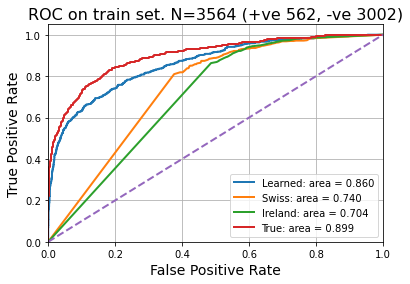

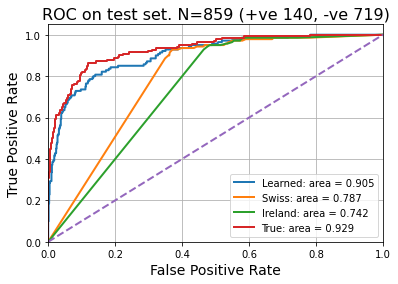

total: 33600, positives: 5383, negatives: 28217
total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 4.037, median size 3
	 Negative bags: mean size 3.951, median size 3
required -ve exposures: 16142
available -ve exposures: 28217
Assignment matrix size: (4431, 17568) (3524, 17568) (17568, 3)
Train size: 3544(+568/-2976), test size: 887(+142/-745)
Average positive samples per bag: 2.008450704225352
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.007, 0.002, 0.005]
	rssi_th: [26.0, 13.0, 18.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.007, 0.009, 0.014]
	rssi_th: [-94.0, -81.0, -63.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.9874134063720703 / step 0.9859525561332703
Iter 4999: batch loss 0.3453, sigmoid_temp 1.000, elapsed time 19.49
Iter 4999, full train loss: step-bins 0.3340, loss sigmoid-bins 0.3277
loss at the end:

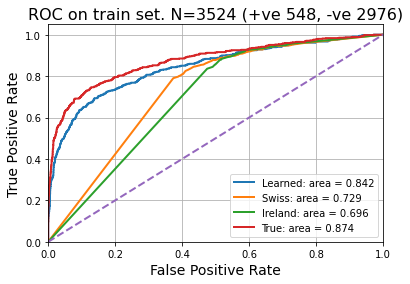

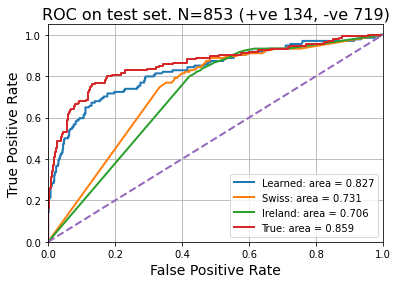

total: 33600, positives: 5389, negatives: 28211
total: 33600, positives: 5389, negatives: 28211
Empirical Bag sizes:
	 Positive bags: mean size 3.852, median size 3
	 Negative bags: mean size 4.040, median size 3
required -ve exposures: 16342
available -ve exposures: 28211
Assignment matrix size: (4426, 17748) (3496, 17748) (17748, 3)
Train size: 3540(+568/-2972), test size: 886(+142/-744)
Average positive samples per bag: 1.980281690140845
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.008, 0.004, 0.005, 0.009]
	rssi_th: [20.0, 37.0, 26.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.008, 0.012, 0.017, 0.026]
	rssi_th: [-100.0, -63.0, -37.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.9697160124778748 / step 0.9818167090415955
Iter 4999: batch loss 0.3983, sigmoid_temp 1.000, elapsed time 22.29
Iter 4999, full train loss: step-bins 0.3368, loss sigmoid-bins 0.3338
loss at the

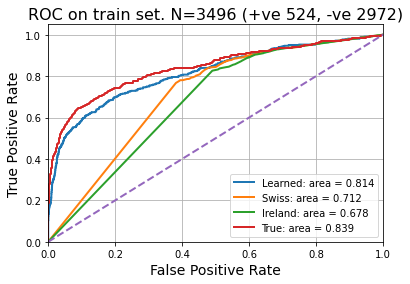

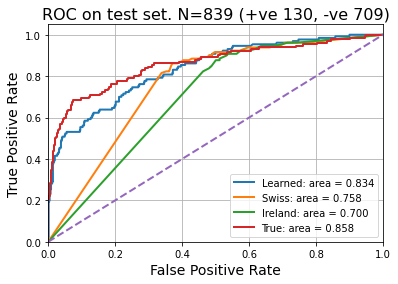

total: 33600, positives: 5393, negatives: 28207
total: 33600, positives: 5393, negatives: 28207
Empirical Bag sizes:
	 Positive bags: mean size 3.958, median size 3
	 Negative bags: mean size 3.953, median size 3
required -ve exposures: 16069
available -ve exposures: 28207
Assignment matrix size: (4423, 17487) (3479, 17487) (17487, 3)
Train size: 3538(+568/-2970), test size: 885(+142/-743)
Average positive samples per bag: 1.9971830985915493
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.008, 0.001, 0.008]
	rssi_th: [33.0, 13.0, 27.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.01, 0.011, 0.02]
	rssi_th: [-87.0, -74.0, -47.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9414864778518677 / step 0.955933153629303
Iter 4999: batch loss 0.3506, sigmoid_temp 1.000, elapsed time 20.60
Iter 4999, full train loss: step-bins 0.3795, loss sigmoid-bins 0.3743
loss at the end

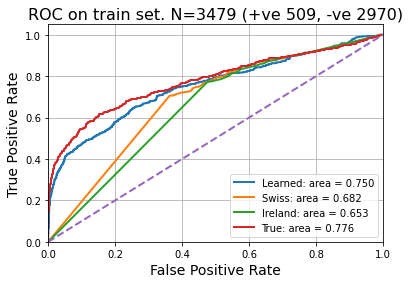

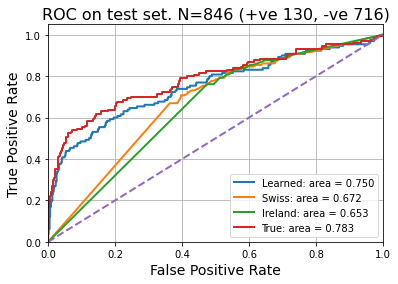

total: 33600, positives: 5316, negatives: 28284
total: 33600, positives: 5316, negatives: 28284
Empirical Bag sizes:
	 Positive bags: mean size 4.003, median size 3
	 Negative bags: mean size 4.005, median size 3
required -ve exposures: 16577
available -ve exposures: 28284
Assignment matrix size: (4487, 17967) (3511, 17967) (17967, 3)
Train size: 3589(+568/-3021), test size: 898(+142/-756)
Average positive samples per bag: 1.9577464788732395
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.003, 0.008, 0.01]
	rssi_th: [25.0, 39.0, 32.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.004, 0.012, 0.022]
	rssi_th: [-95.0, -56.0, -24.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9919105172157288 / step 1.0157204866409302
Iter 4999: batch loss 0.3784, sigmoid_temp 1.000, elapsed time 20.50
Iter 4999, full train loss: step-bins 0.3585, loss sigmoid-bins 0.3562
loss at the e

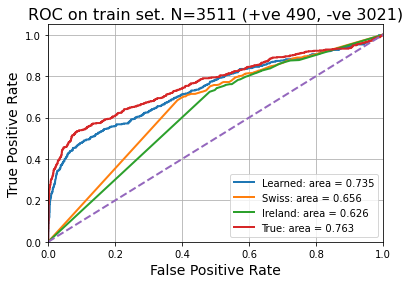

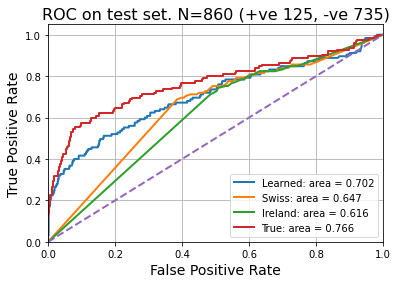

total: 33600, positives: 5420, negatives: 28180
total: 33600, positives: 5420, negatives: 28180
Empirical Bag sizes:
	 Positive bags: mean size 3.996, median size 3
	 Negative bags: mean size 4.043, median size 3
required -ve exposures: 16327
available -ve exposures: 28180
Assignment matrix size: (4401, 17760) (3432, 17760) (17760, 3)
Train size: 3520(+568/-2952), test size: 881(+142/-739)
Average positive samples per bag: 2.0183098591549298
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.007, 0.007, 0.005]
	rssi_th: [18.0, 11.0, 30.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.01, 0.016, 0.022]
	rssi_th: [-102.0, -91.0, -61.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.9204933047294617 / step 0.9216596484184265
Iter 4999: batch loss 0.3186, sigmoid_temp 1.000, elapsed time 19.24
Iter 4999, full train loss: step-bins 0.3866, loss sigmoid-bins 0.3811
loss at the

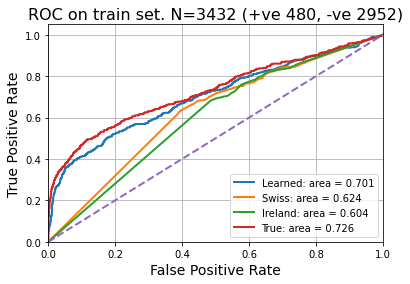

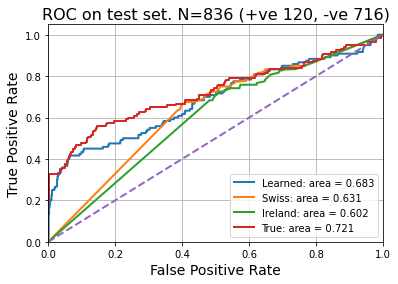

total: 33600, positives: 5315, negatives: 28285
total: 33600, positives: 5315, negatives: 28285
Empirical Bag sizes:
	 Positive bags: mean size 4.077, median size 3
	 Negative bags: mean size 3.958, median size 3
required -ve exposures: 16403
available -ve exposures: 28285
Assignment matrix size: (4488, 17847) (3465, 17847) (17847, 3)
Train size: 3590(+568/-3022), test size: 898(+142/-756)
Average positive samples per bag: 2.0338028169014084
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.009, 0.008, 0.0]
	rssi_th: [36.0, 33.0, 14.0]
	infectiousness: [0.0, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.011, 0.019, 0.019]
	rssi_th: [-84.0, -51.0, -37.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 0.9342672824859619 / step 0.950828492641449
Iter 4999: batch loss 0.3283, sigmoid_temp 1.000, elapsed time 20.36
Iter 4999, full train loss: step-bins 0.3708, loss sigmoid-bins 0.3690
loss at the end: 

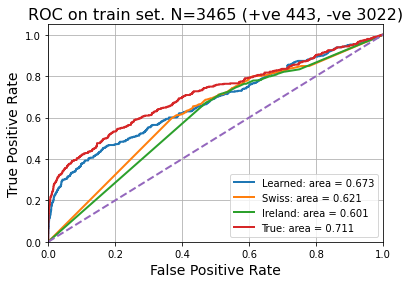

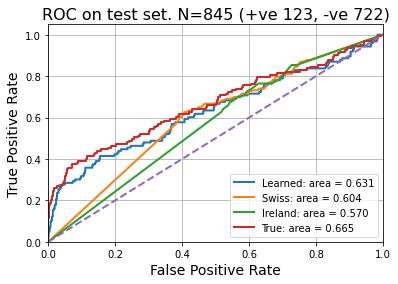

total: 33600, positives: 5415, negatives: 28185
total: 33600, positives: 5415, negatives: 28185
Empirical Bag sizes:
	 Positive bags: mean size 4.015, median size 3
	 Negative bags: mean size 3.983, median size 3
required -ve exposures: 16129
available -ve exposures: 28185
Assignment matrix size: (4405, 17569) (3381, 17569) (17569, 3)
Train size: 3524(+568/-2956), test size: 881(+142/-739)
Average positive samples per bag: 2.028169014084507
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.002, 0.007, 0.001]
	rssi_th: [27.0, 12.0, 33.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.004, 0.011, 0.012]
	rssi_th: [-93.0, -81.0, -48.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.8688393831253052 / step 0.8643661141395569
Iter 4999: batch loss 0.3880, sigmoid_temp 1.000, elapsed time 20.75
Iter 4999, full train loss: step-bins 0.3914, loss sigmoid-bins 0.3912
loss at the 

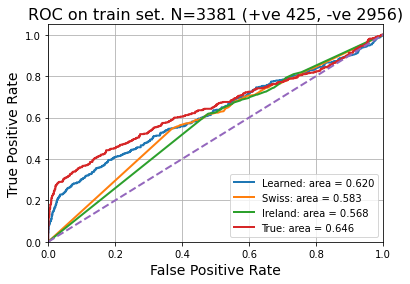

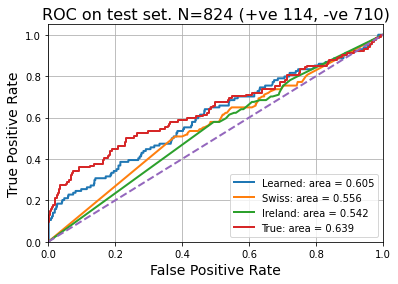

In [98]:
# train for all bag configurations
auc_train_configs = []
auc_test_configs = []
n_trials = 1
n_random_restarts_train = 10
for bag_config in bag_sims:
    auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_config, X_epi,
                                                                       probabilities_true_epi, n_trials=n_trials,
                                                                       n_random_restarts=n_random_restarts_train)
    auc_train_configs.append(auc_train_trials)
    auc_test_configs.append(auc_test_trials)

## Experiments

### 1. Varying maximum bag size

To show the effect that increasing bag size has on the performance of the algorithm. Increasing bag size would increase uncertainty in assigning a risk score, since there is more noise with more observations. Hence, we would expect the performance of the algorithm to decrease.

In [ ]:
bag_size = [4, 8, 16, 32]
for bs in bag_size:
    Bag_Simulator(p_pos=0.6, r_pos=2, p_neg=0.6, r_neg=2, max_bag_size=bs, censor_prob_pos=0.05, censor_prob_neg=0)

### 2. Varying censoring probability

Censoring targets positive exposures. Increasing censoring probability reduces the accuracy of the algorithm since there is less data on positive exposures, which will bias the algorithm against calculating a higher risk score.

### 3. Varying Positive Bag Construction

